# Cleaning: BJH017


This script cleans the data both by abnormal trials and by noisy channels and epileptic activity. Final bad list: 'OL1', 'OL2', 'OL3', 'AR14', 'BR1', 'BR2', 'OL7', 'OL4', 'OL5', 'OL6', 'OL7', 'OL8', 'OL9', 'OL10', 'GR1', 'GR2', 'CR4', 'CR5'

### Prep

In [3]:
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import re
from BCI2kReader import BCI2kReader as b2k
import os
import mne
import IPython
import seaborn as sns

In [2]:
%matplotlib qt5

In [4]:
# helper functions#

def rle(inarray):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            return(z, p, ia[i])
        
def find_bad_trial_times(idx, srate, trial_begins, trial_lengths):
    ''' takes and index of trial lengths, beginnings and the sampling rate and returns the the start time and and
    duration of the times to annotae as BAD '''
    start_time = trial_begins[0][idx]/srate
    duration = trial_lengths[0][idx]/srate
    
    return start_time, duration        

In [7]:
## Prep paths ##

subject = 'BJH017'
ex_raw_data_dir = f"/media/brooke/T7/pacman/raw_data/{subject}"
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [8]:
## Load Data ##

raw_fif = mne.io.Raw(f"{ex_raw_data_dir}/ieeg/{subject}_raw_ieeg.fif")

Opening raw data file /media/brooke/T7/pacman/raw_data/BJH017/ieeg/BJH017_raw_ieeg.fif...
    Range : 0 ... 1963999 =      0.000 ...   982.000 secs
Ready.
Opening raw data file /media/brooke/T7/pacman/raw_data/BJH017/ieeg/BJH017_raw_ieeg-1.fif...
    Range : 1964000 ... 3739199 =    982.000 ...  1869.600 secs
Ready.


In [9]:
## Filtering ##

# load data #
raw_fif.load_data()

# highpass filter @ 1 and lowpass @ 200 #
filtered_data = raw_fif.filter(l_freq=1, h_freq=150) # skip this step for TF analysis, always do this on the least processed data, or do .1 to 250

# remove 60hz line noise #
freqs = (60, 120, 180, 240)
filtered_notch_data = filtered_data.notch_filter(freqs=freqs) 


Reading 0 ... 3739199  =      0.000 ...  1869.600 secs...


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    6.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   15.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13201 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   13.6s


In [10]:
## Load/Save Filtered Data ##

# save #
filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif", overwrite = True)

# load #
# filtered_notch_data = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_ieeg.fif")
events = mne.find_events(filtered_notch_data, output='step', consecutive = False, stim_channel='STI')

Writing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_notched_filtered_ieeg.fif
Closing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_notched_filtered_ieeg.fif
Writing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_notched_filtered_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_notched_filtered_ieeg-1.fif
[done]
482 events found on stim channel STI
Event IDs: [0 1]


In [11]:
filtered_notch_data.info['ch_names']

['EMPTY',
 'EMPTY_2',
 'EMPTY_3',
 'EMPTY_4',
 'REF1',
 'REF2',
 'AR1',
 'AR2',
 'AR3',
 'AR4',
 'AR5',
 'AR6',
 'AR7',
 'AR8',
 'AR9',
 'AR10',
 'AR11',
 'AR12',
 'AR13',
 'AR14',
 'BR1',
 'BR2',
 'BR3',
 'BR4',
 'BR5',
 'BR6',
 'BR7',
 'BR8',
 'BR9',
 'BR10',
 'BR11',
 'BR12',
 'BR13',
 'BR14',
 'BR15',
 'BR16',
 'CR1',
 'CR2',
 'CR3',
 'CR4',
 'CR5',
 'CR6',
 'CR7',
 'CR8',
 'CR9',
 'CR10',
 'CR11',
 'CR12',
 'CR13',
 'CR14',
 'CR15',
 'CR16',
 'DR1',
 'DR2',
 'DR3',
 'DR4',
 'DR5',
 'DR6',
 'DR7',
 'DR8',
 'DR9',
 'DR10',
 'DR11',
 'DR12',
 'DR13',
 'DR14',
 'ER1',
 'ER2',
 'ER3',
 'ER4',
 'ER5',
 'ER6',
 'ER7',
 'ER8',
 'ER9',
 'ER10',
 'ER11',
 'ER12',
 'FR1',
 'FR2',
 'FR3',
 'FR4',
 'FR5',
 'FR6',
 'FR7',
 'FR8',
 'FR9',
 'FR10',
 'FR11',
 'FR12',
 'GR1',
 'GR2',
 'GR3',
 'GR4',
 'GR5',
 'GR6',
 'GR7',
 'GR8',
 'GR9',
 'GR10',
 'GR11',
 'GR12',
 'GR13',
 'GR14',
 'HR1',
 'HR2',
 'HR3',
 'HR4',
 'HR5',
 'HR6',
 'HR7',
 'HR8',
 'HR9',
 'HR10',
 'HR11',
 'HR12',
 'HR13',
 'HR14',


## Cleaning Neural Data

#### Bad Channels

Epileptic channels from my cleaning: 

Noisy channels: 

['EMPTY', 'EMPTY_2', 'EMPTY_3', 'EMPTY_4', 'REF1', 'REF2', 'EMPTY_225', 'EMPTY_226', 'EMPTY_227', 'EMPTY_228', 'EMPTY_229', 'EMPTY_230', 'EMPTY_231', 'EKG1', 'EKG2', 'FP1', 'F3', 'C3', 'P3', 'O1', 'FP2', 'F4', 'C4', 'P4', 'O2', 'F7', 'T7', 'P7', 'F8', 'T8', 'P8', 'F9', 'F10', 'FPZ', 'FZ', 'CZ', 'PZ', 'OZ', 'EKG1', 'EKG2', 'DC01', 'DC02', 'DC03', 'DC04', 'DC05', 'DC06', 'DC07', 'DC08', 'DC09', 'DC10', 'DC11', 'DC12', 'DC13', 'DC14', 'DC15', 'DC16', 'OL1', 'OL2', 'AR14', 'BR1', 'BR2', 'OL7', 'OL4', 'OL5']

In [12]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in filtered_notch_data.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [filtered_notch_data.info['ch_names'][i] for i in bad_channels_index]

filtered_notch_data.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes
filtered_notch_data.info['bads'].extend(['OL1', 'OL2', 'OL3', 'AR14', 'BR1', 'BR2', 'OL7', 'OL4', 'OL5', 'OL6', 'OL7', 'OL8', 'OL9', 'OL10', 'GR1', 'GR2', 'CR4', 'CR5'])  

# remove out of brain electrodes
## TODO hasn't been localized

# remove scalp and dc channels
scalp_dc_channels = ['FP1',
 'F3',
 'C3',
 'P3',
 'O1',
 'FP2',
 'F4',
 'C4',
 'P4',
 'O2',
 'F7',
 'T7',
 'P7',
 'F8',
 'T8',
 'P8',
 'F9',
 'F10',
 'FPZ',
 'FZ',
 'CZ',
 'PZ',
 'OZ',
 'EKG1',
 'EKG2',
 'DC01',
 'DC02',
 'DC03',
 'DC04',
 'DC05',
 'DC06',
 'DC07',
 'DC08',
 'DC09',
 'DC10',
 'DC11',
 'DC12',
 'DC13',
 'DC14',
 'DC15',
 'DC16']

filtered_notch_data.info['bads'].extend(scalp_dc_channels)
filtered_notch_data

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,0 points
Good channels,"201 sEEG, 1 Stimulus"
Bad channels,"EMPTY, EMPTY_2, EMPTY_3, EMPTY_4, REF1, REF2, EMPTY_225, EMPTY_226, EMPTY_227, EMPTY_228, EMPTY_229, EMPTY_230, EMPTY_231, EKG1, EKG2, OL1, OL2, OL3, AR14, BR1, BR2, OL7, OL4, OL5, OL6, OL7, OL8, OL9, OL10, GR1, GR2, CR4, CR5, FP1, F3, C3, P3, O1, FP2, F4, C4, P4, O2, F7, T7, P7, F8, T8, P8, F9, F10, FPZ, FZ, CZ, PZ, OZ, EKG1, EKG2, DC01, DC02, DC03, DC04, DC05, DC06, DC07, DC08, DC09, DC10, DC11, DC12, DC13, DC14, DC15, DC16"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2000.00 Hz
Highpass,1.00 Hz
Lowpass,150.00 Hz


In [13]:
# Remove Channels from filtered data

# remove non seeg electrodes electrodes #
string_lst = ['EMPTY', 'REF', 'ekg']

bad_channels_reg = [re.findall(r"(?=("+'|'.join(string_lst)+r"))", name, re.IGNORECASE) for name in raw_fif.info['ch_names']]
bad_channels_index = [i for i,x in enumerate(bad_channels_reg) if  x]
bad_channels = [raw_fif.info['ch_names'][i] for i in bad_channels_index]

raw_fif.info['bads'].extend(bad_channels)  

# # remove epileptic electrodes
raw_fif.info['bads'].extend(['OL1', 'OL2', 'OL3', 'AR14', 'BR1', 'BR2', 'OL7', 'OL4', 'OL5', 'OL6', 'OL7', 'OL8', 'OL9', 'OL10','GR1', 'GR2', 'CR4', 'CR5']) 

# remove out of brain electrodes
## TODO hasn't been localized

# remove scalp and dc channels
scalp_dc_channels = ['FP1',
 'F3',
 'C3',
 'P3',
 'O1',
 'FP2',
 'F4',
 'C4',
 'P4',
 'O2',
 'F7',
 'T7',
 'P7',
 'F8',
 'T8',
 'P8',
 'F9',
 'F10',
 'FPZ',
 'FZ',
 'CZ',
 'PZ',
 'OZ',
 'EKG1',
 'EKG2',
 'DC01',
 'DC02',
 'DC03',
 'DC04',
 'DC05',
 'DC06',
 'DC07',
 'DC08',
 'DC09',
 'DC10',
 'DC11',
 'DC12',
 'DC13',
 'DC14',
 'DC15',
 'DC16']

raw_fif.info['bads'].extend(scalp_dc_channels)
raw_fif

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,0 points
Good channels,"201 sEEG, 1 Stimulus"
Bad channels,"EMPTY, EMPTY_2, EMPTY_3, EMPTY_4, REF1, REF2, EMPTY_225, EMPTY_226, EMPTY_227, EMPTY_228, EMPTY_229, EMPTY_230, EMPTY_231, EKG1, EKG2, OL1, OL2, OL3, AR14, BR1, BR2, OL7, OL4, OL5, OL6, OL7, OL8, OL9, OL10, GR1, GR2, CR4, CR5, FP1, F3, C3, P3, O1, FP2, F4, C4, P4, O2, F7, T7, P7, F8, T8, P8, F9, F10, FPZ, FZ, CZ, PZ, OZ, EKG1, EKG2, DC01, DC02, DC03, DC04, DC05, DC06, DC07, DC08, DC09, DC10, DC11, DC12, DC13, DC14, DC15, DC16, EMPTY, EMPTY_2, EMPTY_3, EMPTY_4, REF1, REF2, EMPTY_225, EMPTY_226, EMPTY_227, EMPTY_228, EMPTY_229, EMPTY_230, EMPTY_231, EKG1, EKG2, OL1, OL2, OL3, AR14, BR1, BR2, OL7, OL4, OL5, OL6, OL7, OL8, OL9, OL10, GR1, GR2, CR4, CR5, FP1, F3, C3, P3, O1, FP2, F4, C4, P4, O2, F7, T7, P7, F8, T8, P8, F9, F10, FPZ, FZ, CZ, PZ, OZ, EKG1, EKG2, DC01, DC02, DC03, DC04, DC05, DC06, DC07, DC08, DC09, DC10, DC11, DC12, DC13, DC14, DC15, DC16"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2000.00 Hz
Highpass,1.00 Hz
Lowpass,150.00 Hz


#### Bad Epochs from noisy data



In [15]:
# # Annotate Noisy Epochs from Bob's cleaning

# read from csv from interactive session
bad_annots = mne.read_annotations(f"{ex_raw_data_dir}/ieeg/saved_annotations.fif")   


/tmp/ipykernel_6619/74878720.py:4: RuntimeWarning: Invalid tag with only 0/16 bytes at position 423 in file /media/brooke/T7/pacman/raw_data/BJH017/ieeg/saved_annotations.fif
  bad_annots = mne.read_annotations(f"{ex_raw_data_dir}/ieeg/saved_annotations.fif")


#### Bad epochs from bad trial data

In [16]:
## quality check trials ##

# calculate trial onsets and offsets
sti_raw = filtered_notch_data.get_data(picks = ['STI'])
lengths, positionsm, val  = rle(sti_raw[0])

# lengths, beginnings, endings, for trials
trial_lengths = [lengths[x] for x in np.where(val == 1)]
trial_begins = [positionsm[x] for x in np.where(val == 1)]
trial_ends = trial_lengths[0] + trial_begins[0]
trial_baseline = trial_begins[0] - 1000

# lengths, beginnings, endings, for itis
iti_lengths = [lengths[x] for x in np.where(val == 0)]
iti_begins = [positionsm[x] for x in np.where(val == 0)]
iti_ends = iti_begins[0] + iti_lengths[0]

# save trial lengths for later
np.save(f"{preproc_data_dir}/{subject}_trial_lengths.npy", trial_lengths)

In [17]:
# exclude bad trials/apochs from r behavioral analysis (paused trials and no biscuits)

# load bad trial data
bad_trials = np.genfromtxt(f"{raw_data_dir}/behave/{subject}_bad_trials.csv", delimiter = ',', skip_header = 1)

onsets = []
durations = []
for bad in bad_trials:
    start, dur = find_bad_trial_times(int(bad), raw_fif.info['sfreq'], trial_begins, trial_lengths)
    onsets.append(start)
    durations.append(dur)

# update descriptions
descriptions = ['bad'] * len(durations)


In [18]:
# exclude all bad epochs from both bad trials and investigating neural data ##

# combine with bad trial data #
bad_annots.append(onsets, durations, descriptions)

# # apply to filtered data #
filtered_notch_data.set_annotations(bad_annots)

# # apply to not filtered data #
raw_fif.set_annotations(bad_annots)

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,0 points
Good channels,"201 sEEG, 1 Stimulus"
Bad channels,"EMPTY, EMPTY_2, EMPTY_3, EMPTY_4, REF1, REF2, EMPTY_225, EMPTY_226, EMPTY_227, EMPTY_228, EMPTY_229, EMPTY_230, EMPTY_231, EKG1, EKG2, OL1, OL2, OL3, AR14, BR1, BR2, OL7, OL4, OL5, OL6, OL7, OL8, OL9, OL10, GR1, GR2, CR4, CR5, FP1, F3, C3, P3, O1, FP2, F4, C4, P4, O2, F7, T7, P7, F8, T8, P8, F9, F10, FPZ, FZ, CZ, PZ, OZ, EKG1, EKG2, DC01, DC02, DC03, DC04, DC05, DC06, DC07, DC08, DC09, DC10, DC11, DC12, DC13, DC14, DC15, DC16, EMPTY, EMPTY_2, EMPTY_3, EMPTY_4, REF1, REF2, EMPTY_225, EMPTY_226, EMPTY_227, EMPTY_228, EMPTY_229, EMPTY_230, EMPTY_231, EKG1, EKG2, OL1, OL2, OL3, AR14, BR1, BR2, OL7, OL4, OL5, OL6, OL7, OL8, OL9, OL10, GR1, GR2, CR4, CR5, FP1, F3, C3, P3, O1, FP2, F4, C4, P4, O2, F7, T7, P7, F8, T8, P8, F9, F10, FPZ, FZ, CZ, PZ, OZ, EKG1, EKG2, DC01, DC02, DC03, DC04, DC05, DC06, DC07, DC08, DC09, DC10, DC11, DC12, DC13, DC14, DC15, DC16"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2000.00 Hz
Highpass,1.00 Hz
Lowpass,150.00 Hz


## Visualizing Neural Data

next step, working on filtering out the high frequency noise

then look at Marks script to come up with some plot of every trial, sort longest to shortest, with theta power as the color tiome as x, trial on y

Using matplotlib as 2D backend.


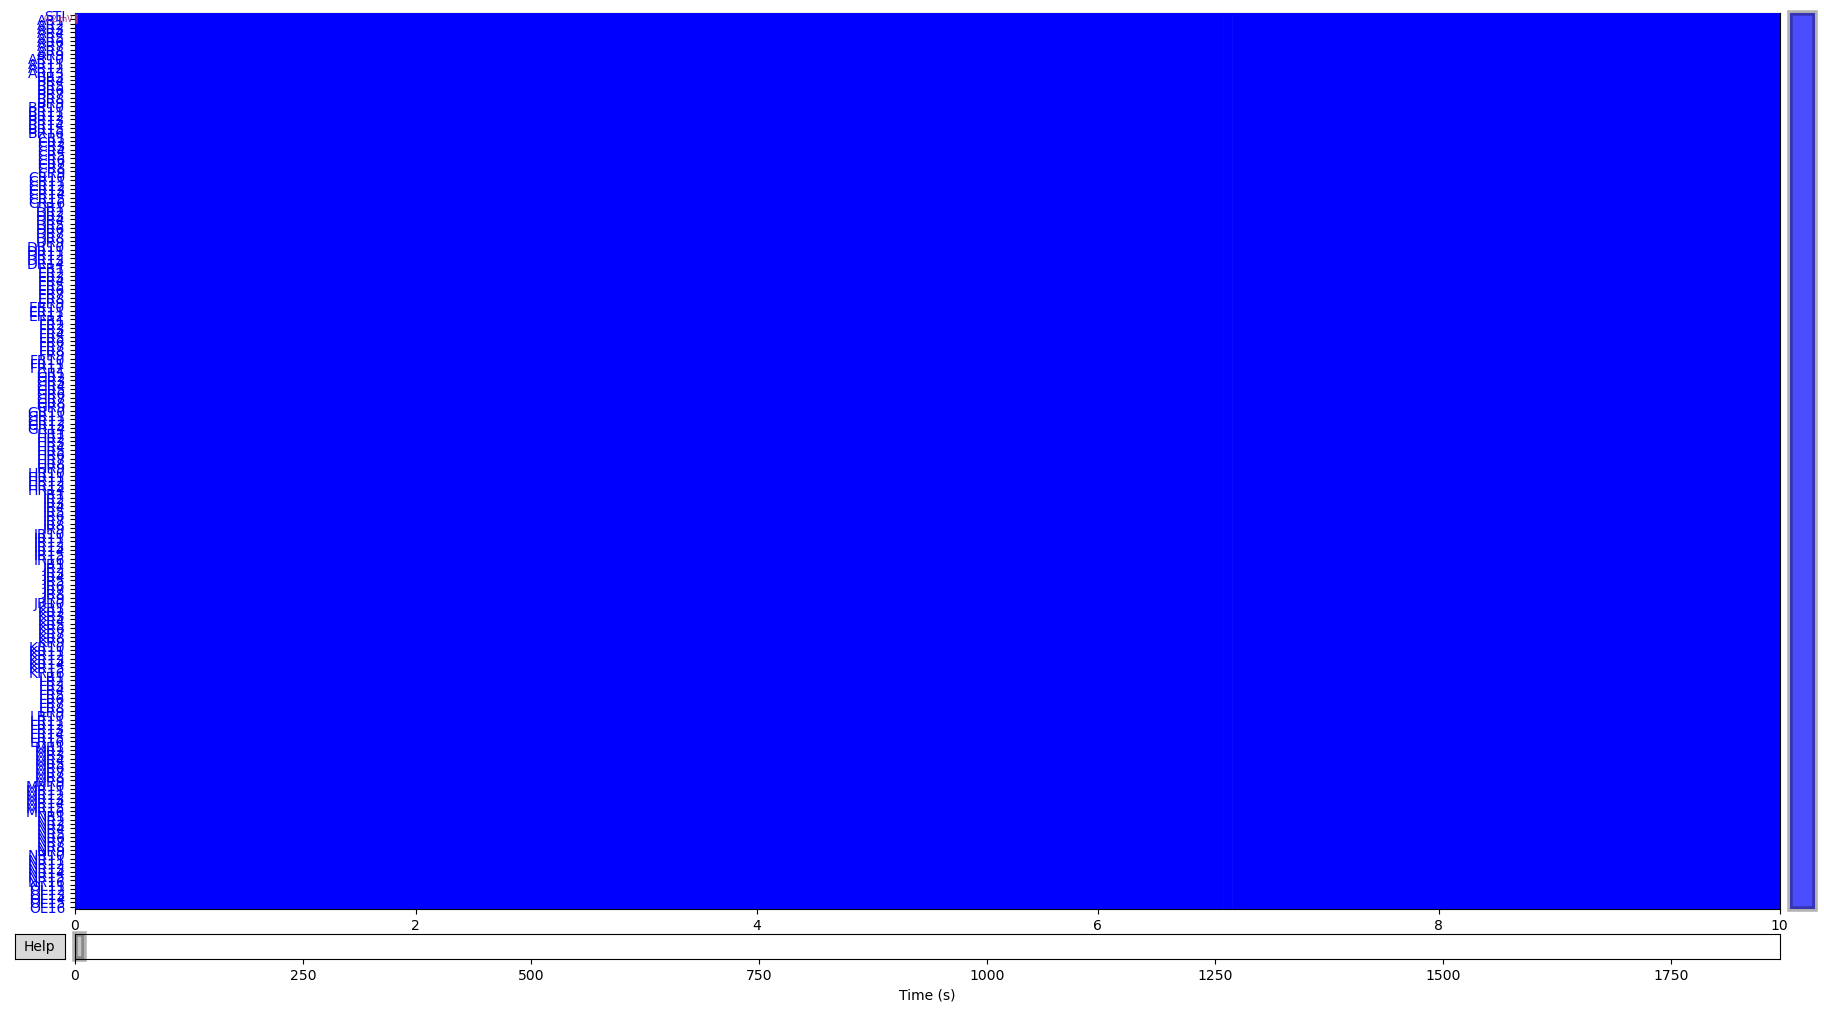

Channels marked as bad:
['GR1', 'GR2', 'CR4', 'CR5']


In [12]:
# plot for cleaning #
filtered_notch_data.drop_channels(filtered_notch_data.info['bads'])
filtered_notch_data.plot(events=events, color='b', bad_color = 'red', n_channels = 230, clipping = None, event_color = 'r')

In [ ]:
# plot psd of all channels #

filtered_notch_data.plot_psd()

In [ ]:
# plot psd of bad channels #

filtered_notch_data.plot_psd(picks = filtered_notch_data.info['bads'])

In [17]:
# # From interactive sessions
# interactive_annot = filtered_notch_data.annotations
# for x in range(0, len(filtered_notch_data.annotations)):
#     print(interactive_annot[x])
    
    
# filtered_notch_data.annotations.save('../ieeg/saved_annotations.fif', overwrite = True) 

OrderedDict([('onset', 126.50472404692081), ('duration', 1.1261560117302025), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 138.30674193548387), ('duration', 1.794811143695), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 344.8520237536657), ('duration', 2.504524046920835), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 546.6950994134897), ('duration', 2.815390029325499), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 819.850682404692), ('duration', 1.853465102639234), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 933.7525120234602), ('duration', 1.6305800586510486), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 1014.1161665689148), ('duration', 1.1906753665689394), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 1018.8842334310849), ('duration', 1.3373102639296803), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict(

/tmp/ipykernel_7704/1650741952.py:7: RuntimeWarning: This filename (../ieeg/saved_annotations.fif) does not conform to MNE naming conventions. All annotations files should end with -annot.fif, -annot.fif.gz, _annot.fif, _annot.fif.gz, .txt or .csv
  filtered_notch_data.annotations.save('../ieeg/saved_annotations.fif', overwrite = True)


## Save Files

In [19]:
# save filtered data #
filtered_notch_data.save(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif", overwrite = True)


# save raw clean data #
raw_fif.save(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif", overwrite = True)


Writing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_notched_filtered_clean_ieeg.fif
Closing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_notched_filtered_clean_ieeg.fif
Writing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_notched_filtered_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_notched_filtered_clean_ieeg-1.fif
[done]
Writing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_raw_clean_ieeg.fif
Closing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_raw_clean_ieeg.fif
Writing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_raw_clean_ieeg-1.fif
Closing /home/brooke/pacman/raw_data/BJH017/ieeg/BJH017_raw_clean_ieeg-1.fif
[done]
